# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# magic word for producing visualizations in notebook
%matplotlib inline
from process import clean_data

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# ML models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
features = pd.read_csv('features.csv', names = ['feature','dtype','unknown_value'], sep=';')
features.head()

,feature,dtype,unknown_value
0,AGER_TYP,categorical,"[-1,0]"
1,ALTERSKATEGORIE_FEIN,ordinal,"[-1,0.9]"
2,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
3,ALTER_HH,ordinal,[0]
4,ANREDE_KZ,categorical,"[-1,0]"


In [3]:
# load in the azdias data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
azdias.shape

(891221, 366)

In [6]:
# count the number of numerical columns
azdias.describe().shape

(8, 360)

In [7]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


## Cleaning Process

- Step 1: Drop Duplicates
- Step 2: Convert Unknown Values to NaNs
- Step 3: Analyse Columns/Rows with Missing Values
- Step 4: Encoding Categorical String Columns
- Step 5: Reduce Columns with the Same Meaning
- Step 6: Reduce Highly Correlated Columns

#### Step 1: Drop Duplicates

In [9]:
azdias_clean = azdias.drop_duplicates()

#### Step 2: Convert Unknown Values to NaNs
From features.csv we see that unknown values are coded with values such as 0 or -1. This needs to be changed to NaN to avoid inaccuracy in future calculation.

In [10]:
# Convert X, XX to -1
azdias_clean[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']] = azdias_clean[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']].replace(['X','XX'], '-1').apply(pd.to_numeric, errors='coerce')


In [11]:
features['unknown_value'] = features['unknown_value'].replace(["['-1','X']"], "[-1]")
features['unknown_value'] = features['unknown_value'].replace(["['-1','XX']"], "[-1]")

In [12]:
# convert unknown numerical values to NaN
for idx in features.index.values:
    column_name = features.feature[idx]
    lst = features.iloc[idx, 2].strip('][').split(',')
    # if unknown value list is not empty, change list values to NaNs
    if lst[0] != '':
        azdias_clean[column_name] = azdias_clean[column_name].replace(lst, np.nan)

#### Step 3: Analyse Columns/Rows with Missing Values

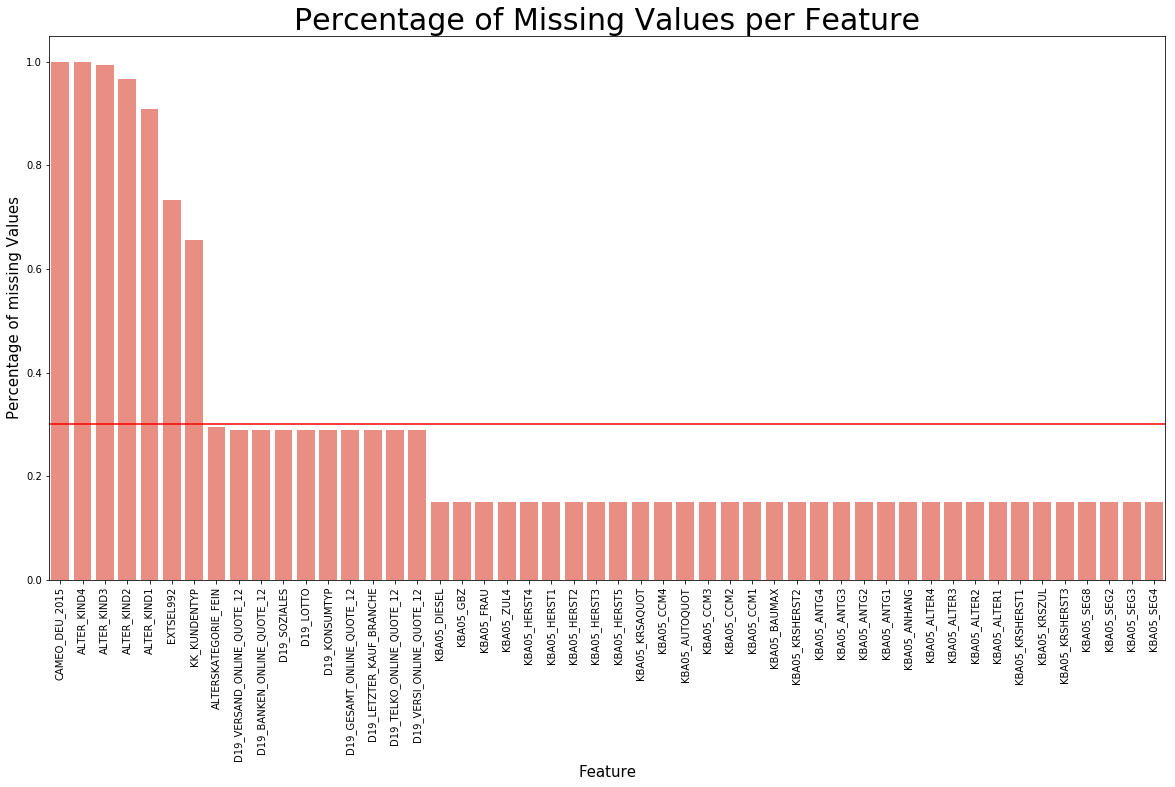

In [13]:
plt.figure(figsize=(20,10))


missing_col_df = azdias_clean.isnull().sum().reset_index(name = 'Number of Missing Values')
missing_col_df['Percentage of Missing Values'] = missing_col_df['Number of Missing Values']/azdias_clean.shape[0]
missing_col_df.sort_values(by='Percentage of Missing Values', ascending=False, inplace=True)

sns.barplot(x='index', y='Percentage of Missing Values', 
            data = missing_col_df.head(50),order=missing_col_df.head(50)['index'], 
            color="salmon")

plt.title('Percentage of Missing Values per Feature', fontsize=30)
plt.axhline(y=0.3, color='r', linestyle='-') # horizontal line to display 30% of total values
plt.xticks(rotation=90)
plt.xlabel('Feature',fontsize=15)
plt.ylabel('Percentage of missing Values', fontsize=15)
plt.show()

From the graph above it can be seen that there are a few columns having > 30% unknown values. Due to the high proportion of unknown values, simply filling them with mean values may not provide true representation of the feature demographics. Therefore, we decide to drop these columns.

In [14]:
# drop columns with high proportion of missing values
col_to_drop = missing_col_df[missing_col_df['Percentage of Missing Values'] > 0.3]['index'].tolist()
azdias_clean = azdias_clean.drop(labels = col_to_drop, axis = 1)
azdias_clean.shape

(891221, 359)

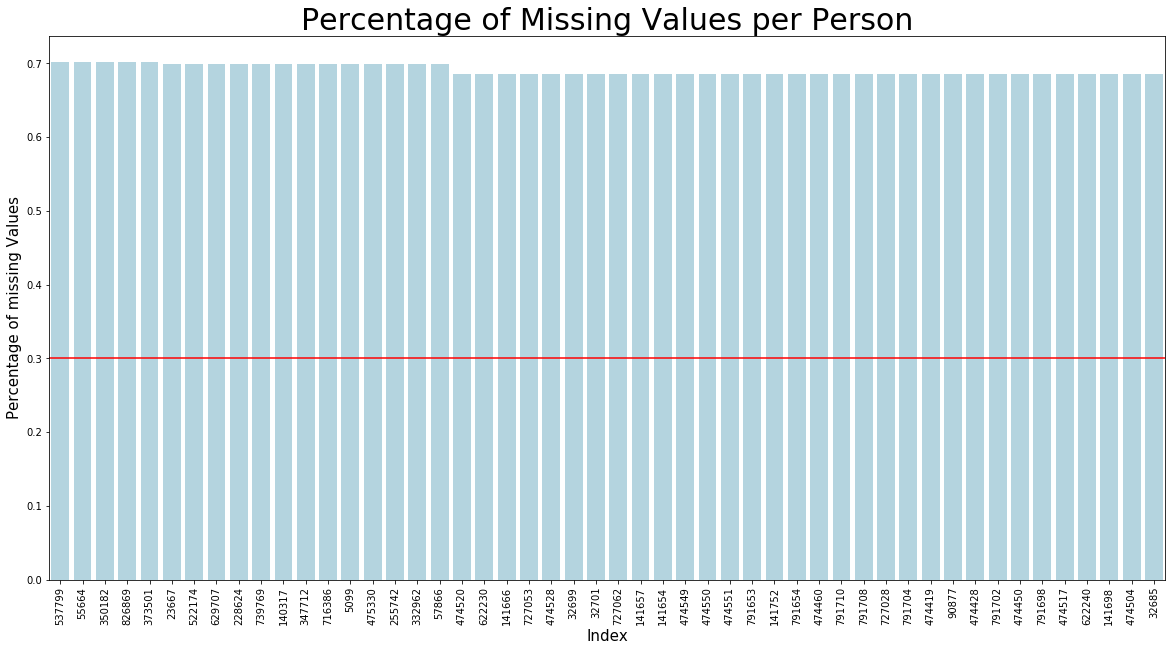

In [15]:
plt.figure(figsize=(20,10))


missing_row_df = azdias_clean.isnull().sum(axis=1).reset_index(name = 'Number of Missing Values')
missing_row_df['Percentage of Missing Values'] = missing_row_df['Number of Missing Values']/azdias_clean.shape[1]
missing_row_df.sort_values(by='Percentage of Missing Values', ascending=False, inplace=True)

sns.barplot(x='index', y='Percentage of Missing Values', 
            data = missing_row_df.head(50),order=missing_row_df.head(50)['index'], 
            color="lightblue")

plt.title('Percentage of Missing Values per Person', fontsize=30)
plt.axhline(y=0.3, color='r', linestyle='-') # horizontal line to display 30% of total values
plt.xticks(rotation=90)
plt.xlabel('Index',fontsize=15)
plt.ylabel('Percentage of missing Values', fontsize=15)
plt.show()

Of all 891k population in the dataset, 12% have more than 30% missing values. We will drop these rows.

In [16]:
row_to_drop = missing_row_df[missing_row_df['Percentage of Missing Values'] > 0.3]['index'].tolist()
azdias_clean = azdias_clean.drop(labels = row_to_drop)
azdias_clean.shape

(785421, 359)

#### Step 4: Encoding Categorical String Columns

In [17]:
azdias_clean.select_dtypes(include=['object']).columns

Index(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'], dtype='object')

As D19_LETZTER_KAUF_BRANCHE & EINGEFUEGT_AM are not explained in the features file, we decide to remove as we are unsure of the true nature of these two features. For OST_WEST_KZ, we will convert O/W to numerical values 0/1.

In [18]:
azdias_clean = azdias_clean.drop(labels=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis = 1)

In [19]:
# Encode OST_WEST_KZ with numerical values
azdias_clean['OST_WEST_KZ'] = azdias_clean['OST_WEST_KZ'].replace(['O','W'],[0, 1]).astype(float)
azdias_clean['OST_WEST_KZ'].value_counts() 

1.0    619287
0.0    166134
Name: OST_WEST_KZ, dtype: int64

#### Step 5: Reduce Columns with the Same Meaning

In features.csv we see that same features are described in GROB(rough) and FEIN(fine) categories (such as LP_FAMILIE_GROB,LP_FAMILIE_FEIN), we need to decide which category to keep based on which category has fewer missing values.

In [20]:
cols_same_meaning = [x for x in features.feature.tolist() if 'GROB' in x]+[x for x in features.feature.tolist() if 'FEIN' in x]
missing_col_df[missing_col_df['index'].isin(cols_same_meaning)]

,index,Number of Missing Values,Percentage of Missing Values
8,ALTERSKATEGORIE_FEIN,262947,0.295041
306,LP_FAMILIE_GROB,4854,0.005446
309,LP_STATUS_FEIN,4854,0.005446
307,LP_LEBENSPHASE_FEIN,4854,0.005446
310,LP_STATUS_GROB,4854,0.005446
305,LP_FAMILIE_FEIN,4854,0.005446
308,LP_LEBENSPHASE_GROB,4854,0.005446
95,D19_WEIN_FEINKOST,0,0.000000
365,ALTERSKATEGORIE_GROB,0,0.000000


From the above table we will drop ALTERSKATEGORIE_FEIN and keep ALTERSKATEGORIE_GROB, for the rest measures, since the percentage of missing values is the same, we would prefer the FEIN feature as it provides more granularity of the feature.

In [21]:
azdias_clean = azdias_clean.drop(labels = ['ALTERSKATEGORIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_GROB','LP_LEBENSPHASE_GROB'], 
                                axis = 1)


#### Step 6: Reduce Highly Correlated Columns

There are two main reasons why highly correlated columns should be reduced. One is that we would like to keep features as distinct as possible so that we can understand the customer demographics from different perspectives. The other is for the efficiency in the modelling purpose.

In [22]:
# Create correlation matrix
corr_matrix = azdias_clean.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [23]:
# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
len(to_drop)

41

In [24]:
azdias_clean = azdias_clean.drop(azdias_clean[to_drop], axis=1)

### Data Cleaning for Customers File

In [25]:
# consolidate all cleanning steps into one function clean_data
# function stored in process.py

customers_clean = clean_data(customers, features)

Done removing duplicates
Done Converting unknown numerical values to NaN
Done dropping columns with more than 30% missing values
Done dropping rows with more than 30% missing values
Done encoding categorical columns
Done keeping either GROB or FEIN version of the feature
Done dropping highly correlated features
 
*** All data cleaning steps complete ***


In [26]:
azdias_clean = clean_data(azdias, features)

Done removing duplicates
Done Converting unknown numerical values to NaN
Done dropping columns with more than 30% missing values
Done dropping rows with more than 30% missing values
Done encoding categorical columns
Done keeping either GROB or FEIN version of the feature
Done dropping highly correlated features
 
*** All data cleaning steps complete ***


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Goals:

For each dataset:
- To analyse the explainability of each feature 
- To form clusters based on the features 
- To compare the differences in clusters from both datasets in order to identify the potential characteristics of the customers

#### Steps:

- Normalize data
- Reduce dimensions
- Find clusters
- Cluster feature comparison between azdias and customers datasets


In [29]:
customers_clean = customers_clean.drop(labels=['PRODUCT_GROUP','CUSTOMER_GROUP','LNR'], axis = 1)


In [30]:
azdias_clean = azdias_clean.dropna()
customers_clean = customers_clean.dropna()


#### Normalize Data

Prior to PCA, we need to standardize the features. This is because PCA directions are highly sensitive to data scaling, and we need to standardize the features before PCA if the features were measured on different scales and we want to assign equal importance to all features.

To address the outliers, we decide to use RobustScaler to standardize both datasets. This Scaler removes the median and scales the data between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). 

In [31]:
# Use SimpleImputer to fill the means
#imp_mean = Imputer(missing_values=np.nan, strategy='median')
#Imp = Imputer(missing_values=np.nan, strategy='median')


In [32]:
# azdias_imputed = pd.DataFrame(Imp.fit_transform(azdias_clean.values),
#                           columns=azdias_clean.columns)

# customers_imputed = pd.DataFrame(Imp.fit_transform(customers_clean.values),
#                           columns=customers_clean.columns)

In [33]:
def scale_data(data):
    '''
    
    Normalize data to prepare for PCA
    
    '''
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled

In [34]:
azdias_scaled = scale_data(azdias_clean)
customers_scaled = scale_data(customers_clean)

#### Reduce Dimensions

Use PCA to reduce dimensions of features by grouping them into components. 

Plot the variance of each component as well as Visualizing the Cumulative Variance.


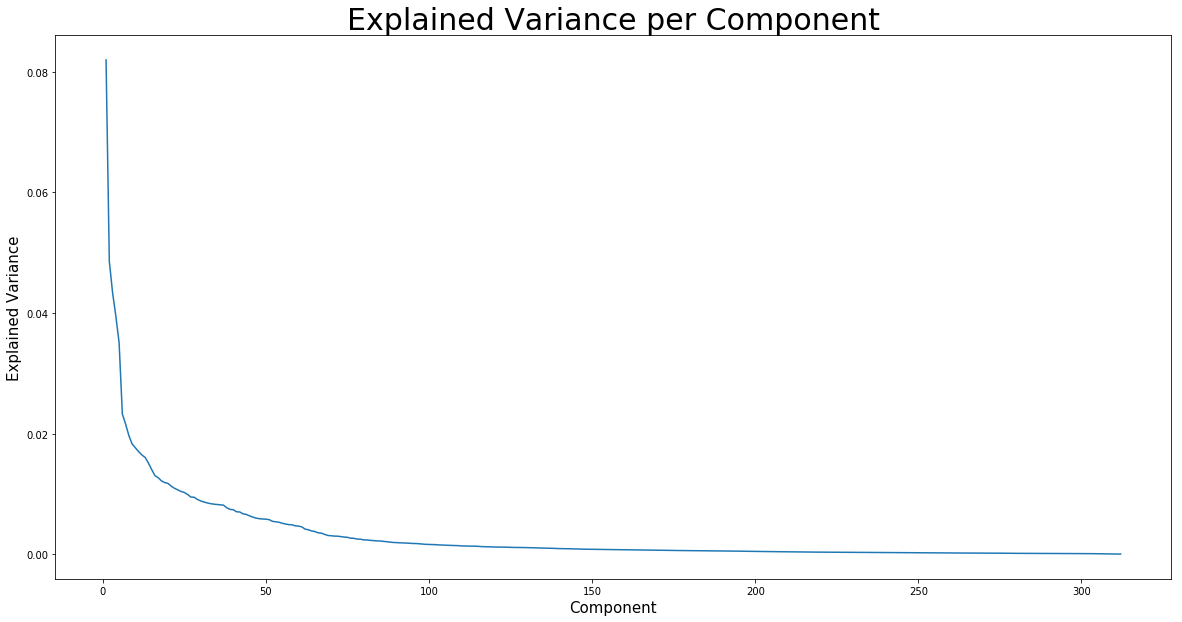

In [35]:
# create a plot to visualize the explained variance of each component using Azidias data
plt.figure(figsize=(20,10))

pca = PCA()
data_pca = pca.fit_transform(azdias_scaled)

num_components = len(pca.explained_variance_ratio_)
x = np.arange(1, num_components+1)
y = pca.explained_variance_ratio_
    
plt.title('Explained Variance per Component', fontsize=30)
plt.xlabel('Component', fontsize=15)
plt.ylabel('Explained Variance', fontsize=15)
    
    
plt.plot(x, y)
plt.show()


In [36]:
def calc_pca(data):
    '''
    
    Calculate PCA & plot the cumulative PCA variance graph
     
    '''
    pca = PCA()
    data_pca = pca.fit_transform(data)
    

    num_components = len(pca.explained_variance_ratio_)
    x = np.arange(1, num_components+1)
    y = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(20,10))
    plt.plot(x, y)
    plt.title('Cumulative Explained Variance per Component', fontsize=30)
    plt.xlabel('Component', fontsize=15)
    plt.ylabel('Cumulative Explained Variance', fontsize=15)
    
    # 100 components
    plt.hlines(y=y[99], xmin=0, xmax=99, color='red', linestyles='-',zorder=3)
    plt.vlines(x=99, ymin=0, ymax=y[99], color='red', linestyles='-',zorder=4)
    
    # 200 components
    plt.hlines(y=y[199], xmin=0, xmax=199, color='red', linestyles='-',zorder=3)
    plt.vlines(x=199, ymin=0, ymax=y[199], color='red', linestyles='-',zorder=4)

    plt.show()
    
    return data_pca
    

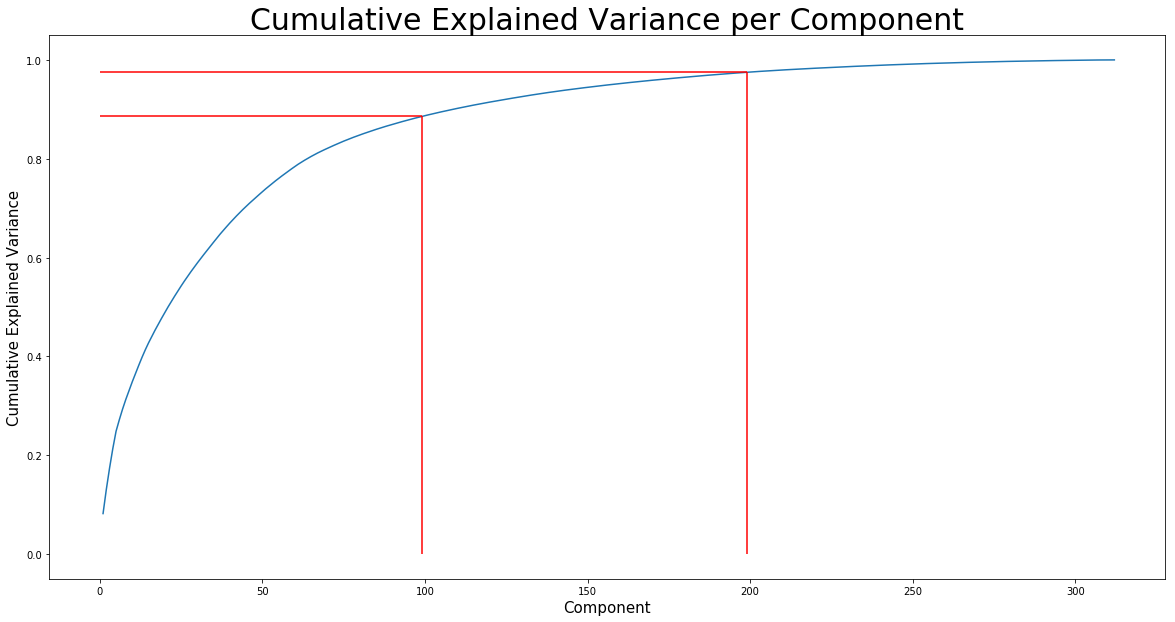

In [37]:
azdias_pca = calc_pca(azdias_scaled)


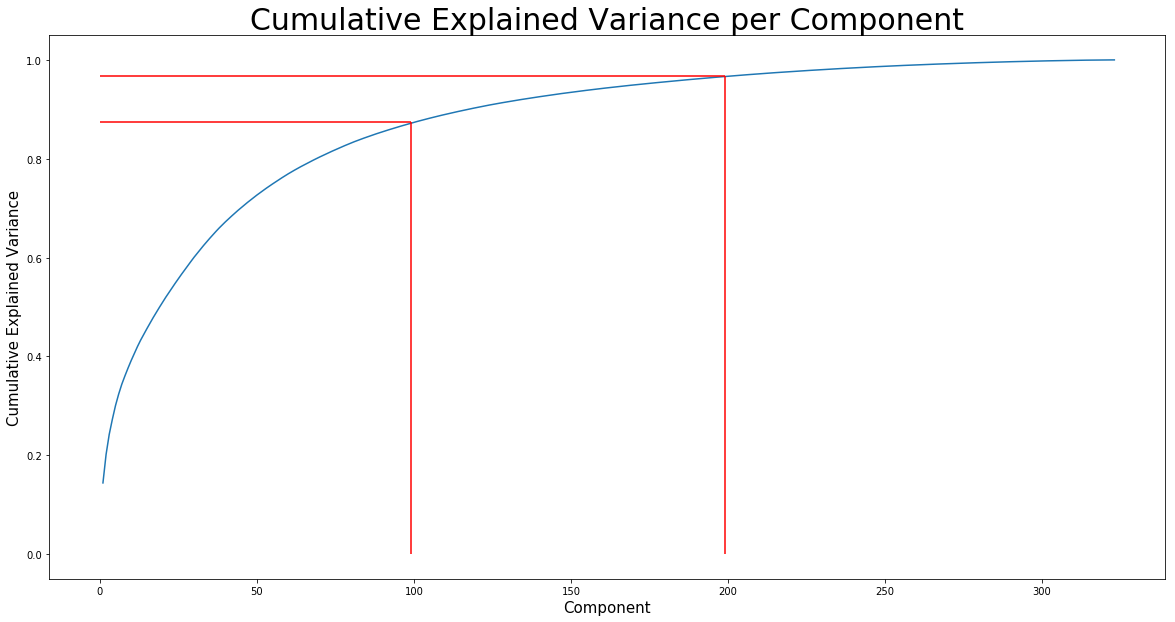

In [38]:
customers_pca = calc_pca(customers_scaled)


From the above graphs we can see that, for both datasets, 100 components can explain over 80% of the variance. 200 components explains almost all variance. First component explains 0.08 variance, much more than the rest of the components.

#### Find Clusters

We use MiniBatchKMeans to identify the optimal number of clusters to be analysed. Choosing miniBatchKMeans over Kmeans is because the former mathod selects smaller number of random samples to form the cluster. This makes the clustering process less computational costly.


In [39]:
def calc_kmeans(data_oca):
    ''' calculate kmeans of different cluster size and create a plot to identify optimal cluster size
    
    Args:
        data_scaled - normalized dataset
    
    Returns: 
        kmeans plot
    '''
    
    n_clusters = np.arange(1,21,1)
    
    inertia_list = []
    for n in n_clusters: # Create k-mean object
        kmeans_obj = MiniBatchKMeans(n_clusters=n, random_state=0, batch_size=1000)
        model = kmeans_obj.fit(data_pca)
        inertia_list.append(model.inertia_)
        
    plt.figure(figsize=(20,10))
    plt.plot(n_clusters, inertia_list)
    plt.title('Optimal Cluster Size Search - Elbow Method', fontsize=30)
    plt.xlabel('Number of Clusters', fontsize=15)
    plt.ylabel('Kmeans Inertia', fontsize=15)
    
    plt.axvline(x=10, color='red')
    
    
    plt.show()
    

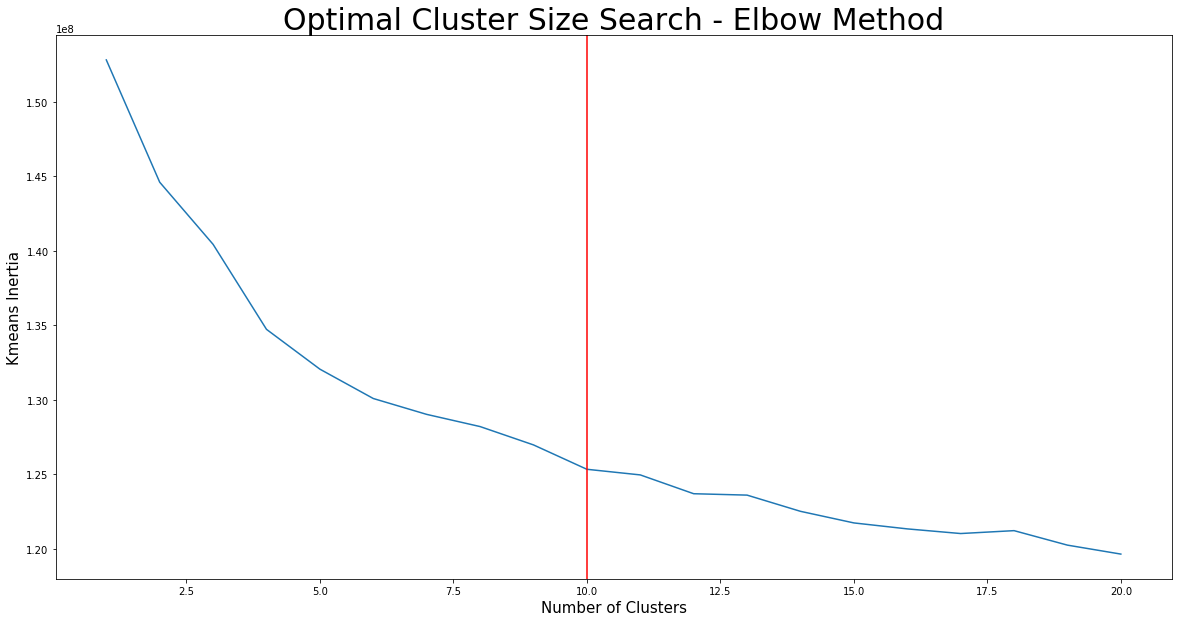

In [40]:
calc_kmeans(azdias_pca)

The above graph shows that, when the number of clusters is 10, the elbow point exists. This suggests that the kmeans inertia, i.e. the sum of squared distance between each point on cluster and the cluster centre is siginificantly decreasing as the number of clusters approaches to 10. afterwards, the kmeans inertia decreases more slowly. Therefore, we determine that 10 is the optimal cluster size.

#### Cluster Feature Comparison between Azdias and Customers Datasets

Compare cluster size between general public (azdias) and customer data

Check the top features of the clusters and identify the differences in features 

In [41]:
# According to the Elbow graph we deterrmine the clusters number as 10. Applying k-means algorithm to the X dataset.
kmeans = MiniBatchKMeans(n_clusters=10, init ='k-means++', max_iter=300, n_init=10,random_state=0)

# use the fit predict method to identify which cluster each obervation belongs to
azdias_pred = kmeans.fit_predict(azdias_pca)
customer_pred = kmeans.fit_predict(customers_pca)

In [42]:
def cluster_size(data_pred):
    ''' Identify the number of items in each cluster
    
    Args:
        data_pred: An array of cluster number for each item index
        
    Returns:
        cluster_df: A dataframe that summerizes the size of each cluster
    '''
    
    cluster_df = pd.DataFrame({
                'cluster': np.unique(data_pred),
                'size':np.bincount(data_pred),
                'pct': np.bincount(data_pred)/data_pred.shape[0]
    })
    
    return cluster_df

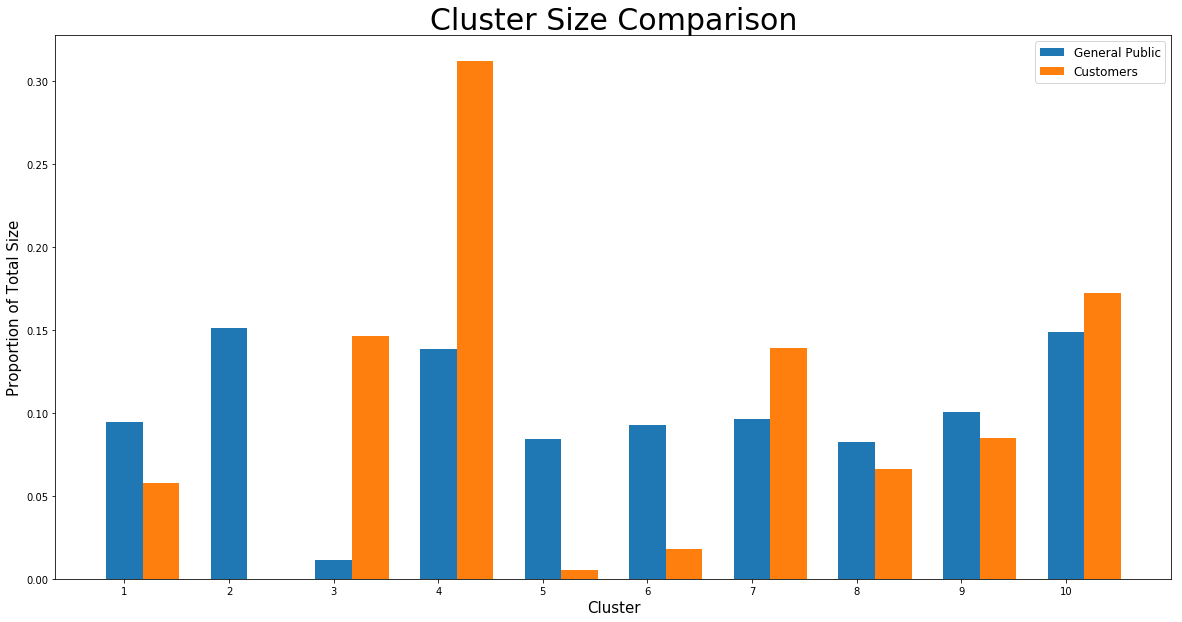

In [43]:
# plot the cluster size comparison between general public and customers
azdias_cluster_size = cluster_size(azdias_pred)
customers_cluster_size = cluster_size(customer_pred)

barwidth = 0.35
x_tick = np.arange(1,11,1)

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x_tick, azdias_cluster_size.pct, barwidth, label='General Public')
rects2 = ax.bar(x_tick + barwidth, customers_cluster_size.pct, barwidth, label='Customers')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Cluster', fontsize=15)
ax.set_ylabel('Proportion of Total Size', fontsize=15)
ax.set_title('Cluster Size Comparison', fontsize=30)
ax.set_xticks(x_tick)
ax.set_xticklabels(x_tick)
ax.legend(fontsize='large')

plt.show()

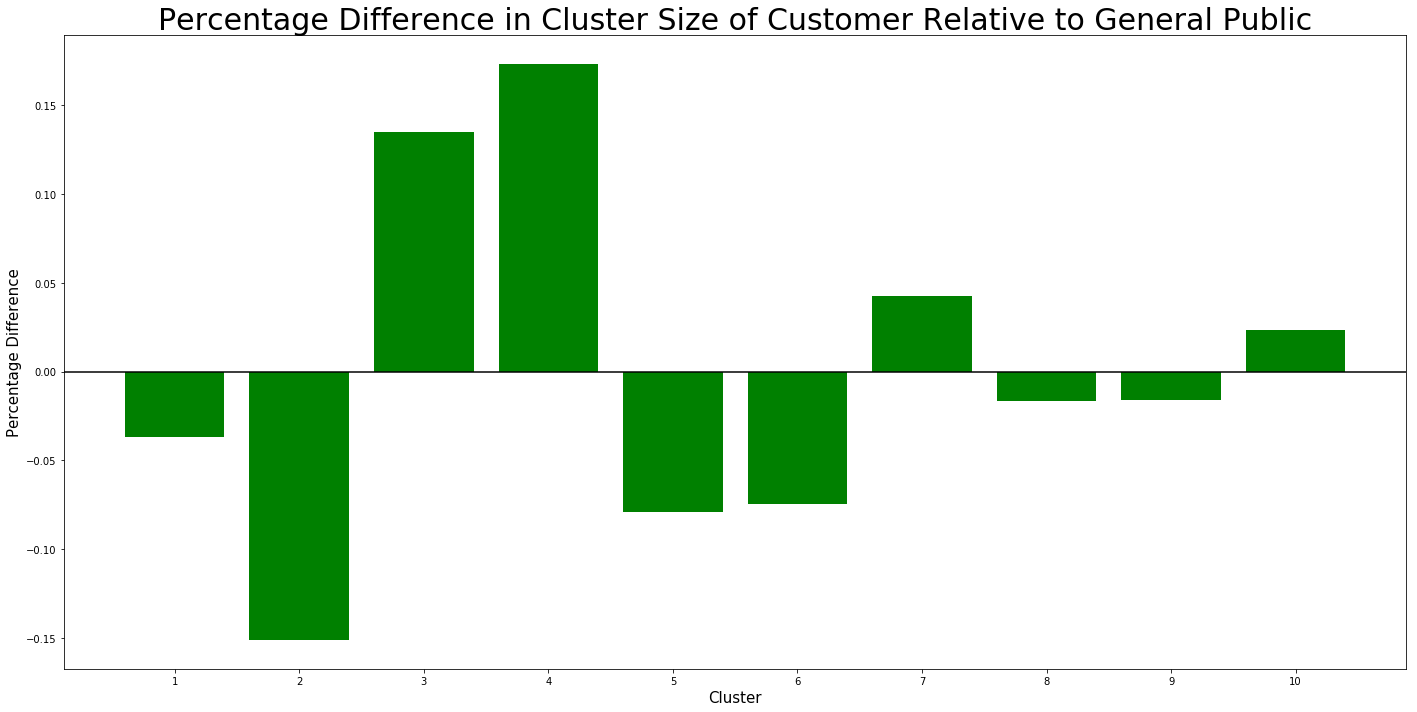

In [44]:
# plot the percentage difference between general public and customers for each cluster
cluster_size_comb = pd.merge(azdias_cluster_size, customers_cluster_size, on='cluster')
cluster_size_comb['diff'] = cluster_size_comb['pct_y'] - cluster_size_comb['pct_x']


plt.figure(figsize=(20,10))
x_tick = np.arange(1,11,1)

plt.bar(x_tick, cluster_size_comb['diff'], color='green')

           
plt.title('Percentage Difference in Cluster Size of Customer Relative to General Public', fontsize=30)
plt.xlabel('Cluster', fontsize=15)
plt.xticks(x_tick)
plt.ylabel('Percentage Difference', fontsize=15)


plt.axhline(y=0, color='black')

plt.tight_layout()
plt.show()

From the above graph, we can see that relative to general public, customers data is overrepresented in Cluster 3，4, 7, 10, and underrepresented in Cluster 1，2，5，6，8，9

Next, we are going to look into the top features in the overrepresented clusters to identify customer characteristics.

In [45]:
# Create a function to get top features of a given cluster


def top_features(data_scaled, data_clean, cluster_num, top_n):
    
    """For a given component, list the top N features 
    Args: 
        data_scaled: standardized data
        data_clean: cleaned data with all features as their columns
        cluster_num: cluster number
        top_n: top n features
        
    Returns: 
        list of top features ranked by coeffient between each component and the feature
        
    """    
    
    pca = PCA()
    pca.fit_transform(data_scaled)
    
    listing = pd.DataFrame({
                        'Features':data_clean.columns.tolist(),
                        'Weights':pca.components_[cluster_num]}).sort_values('Weights', axis=0, ascending=False).values.tolist()

    return listing[:top_n]

In [46]:
# get most relevant features of the customer overrepresented clusters 
key_features = []

for cluster in [3,4,7,10]:
    feature_l = top_features(customers_clean, customers_clean, cluster, 5)
    key_features += feature_l
    


In [47]:
key_features

[['GEMEINDETYP', 0.7480174849837583],
 ['ANZ_HAUSHALTE_AKTIV', 0.545247120282137],
 ['WOHNLAGE', 0.10027758213161939],
 ['INNENSTADT', 0.06945177932472049],
 ['BALLRAUM', 0.05061922172177725],
 ['VERDICHTUNGSRAUM', 0.8797614046690623],
 ['GEMEINDETYP', 0.2358947898372055],
 ['ALTER_HH', 0.18710890235882144],
 ['D19_GESAMT_ONLINE_QUOTE_12', 0.12498573898786433],
 ['LP_FAMILIE_FEIN', 0.11218453217744657],
 ['D19_GESAMT_ONLINE_QUOTE_12', 0.3776248223010431],
 ['EINGEZOGENAM_HH_JAHR', 0.19257075887124694],
 ['D19_GESAMT_ANZ_12', 0.09264843751135442],
 ['W_KEIT_KIND_HH', 0.0727119927162371],
 ['ONLINE_AFFINITAET', 0.05827251439344282],
 ['SEMIO_KULT', 0.26562713975108926],
 ['LP_FAMILIE_FEIN', 0.2369502381444067],
 ['SEMIO_VERT', 0.236149535475942],
 ['SEMIO_FAM', 0.21446132247823074],
 ['LP_STATUS_FEIN', 0.19156936017260595]]

In [48]:
key_features.remove(['EINGEZOGENAM_HH_JAHR', 0.19257075887124694])

In [49]:
#key_features.remove(['EINGEZOGENAM_HH_JAHR', 0.19257075887124694])
key_feature_names = [item[0] for item in key_features] 
key_feature_names = set(key_feature_names).intersection(features.feature.tolist())

azdias_features = azdias_clean[azdias_clean.columns.intersection(key_feature_names)]
customers_features = customers_clean[customers_clean.columns.intersection(azdias_features.columns.tolist())]

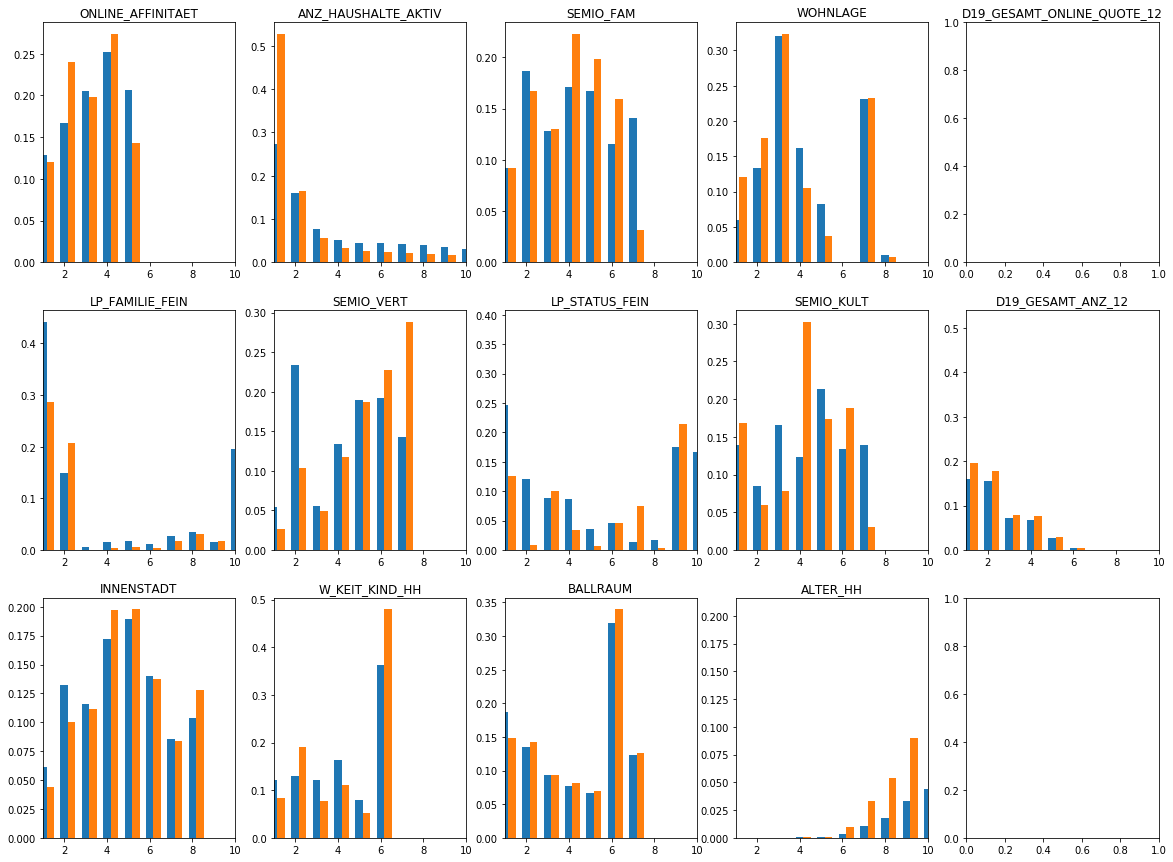

In [50]:
# plot the difference between general public and customers given the key features
fig, axs = plt.subplots(3, 5,figsize=(20,15))
barwidth = 0.35

# ax locations
ax_locs = []
col_length = [0,1,2,3,4]
for pair in itertools.product(col_length, repeat=2):
    if pair[0] == 4:
        break
    ax_locs.append(pair)
    
    
    
    
for feature, ax_loc in zip(key_feature_names, ax_locs):
    try:
        axs[ax_loc[0], ax_loc[1]].set_title(feature)
        temp_df = pd.DataFrame({'pct_customers':customers_features[feature].value_counts()/customers_features.shape[0]})
        temp_df_azdias = pd.DataFrame({'pct_azdias':azdias_features[feature].value_counts()/azdias_features.shape[0]})
        temp_df = pd.concat([temp_df, temp_df_azdias],axis=1)

        axs[ax_loc[0], ax_loc[1]].bar(temp_df.index, temp_df.pct_azdias, barwidth, label='General Public')
        axs[ax_loc[0], ax_loc[1]].bar(temp_df.index + barwidth, temp_df.pct_customers, barwidth, label='General Public')


        axs[ax_loc[0], ax_loc[1]].set_xlim([1, 10])
        
    except:
        continue
        
plt.show()

From the above features, it can be seen that, the customers tend to:

- live with few other households in the building
- be unlikely to have kids
- be houseowners
- be middle-aged or elderly

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [51]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
# clean data
mailout_train = clean_data(mailout_train, features)

Done removing duplicates
Done Converting unknown numerical values to NaN
Done dropping columns with more than 30% missing values
Done dropping rows with more than 30% missing values
Done encoding categorical columns
Done keeping either GROB or FEIN version of the feature
Done dropping highly correlated features
 
*** All data cleaning steps complete ***


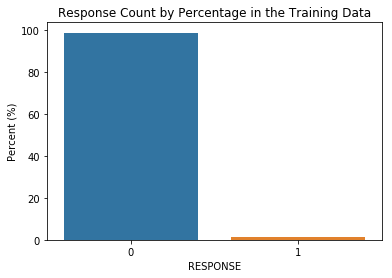

In [53]:
# check response rate of the training data

ax = sns.barplot(x="RESPONSE", y="RESPONSE", data=mailout_train, estimator=lambda x: len(x) / len(mailout_train) * 100)
ax.set(ylabel="Percent (%)")
ax.set_title('Response Count by Percentage in the Training Data')

plt.show()

It can be seen that only 1% of the training data gives positive responses, whereas 99% provides negative responses.

In [54]:
y_train = mailout_train.RESPONSE.tolist()
mailout_train_clean = mailout_train.drop(['RESPONSE','LNR'], axis=1)
mailout_train_clean = mailout_train_clean.fillna(mailout_train_clean.mean())
X_train = scale_data(mailout_train_clean)

In [55]:
def apply_model(clf, param_grid, x=X_train, y=y_train):
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print('Best Score:', grid.best_score_)
    print(grid.best_estimator_)
    
    return grid.best_estimator_

In [56]:
# LogisticRegression
lor = LogisticRegression(random_state=28)
apply_model(lor, {})

Best Score: 0.69012272397
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=28, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=28, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
# BaggingClassifier
bac = BaggingClassifier(random_state=28)
apply_model(bac, {})

Best Score: 0.578898992569
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=28,
         verbose=0, warm_start=False)


BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=28,
         verbose=0, warm_start=False)

In [58]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=28)
apply_model(rfc, {})

Best Score: 0.533223262519
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=28, verbose=0, warm_start=False)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=28, verbose=0, warm_start=False)

In [59]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=28)
apply_model(gbc, {})

Best Score: 0.772215266589
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=28, subsample=1.0, verbose=0,
              warm_start=False)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=28, subsample=1.0, verbose=0,
              warm_start=False)

In [60]:
# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=12)
apply_model(abc, {})

Best Score: 0.757182951993
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=12)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=12)

In [61]:
gbc_model = apply_model(gbc, {})

Best Score: 0.772215266589
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=28, subsample=1.0, verbose=0,
              warm_start=False)


In [62]:
# analyse the most important features of the model
fi = pd.DataFrame({'FI':gbc_model.feature_importances_}, index=mailout_train_clean.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
D19_SOZIALES,0.112460
KBA13_ANZAHL_PKW,0.033680
VERDICHTUNGSRAUM,0.025971
GEBURTSJAHR,0.023687
D19_GESAMT_OFFLINE_DATUM,0.020209
GFK_URLAUBERTYP,0.016848
ANZ_TITEL,0.016796
KBA05_SEG1,0.016733
ANZ_HAUSHALTE_AKTIV,0.016380
GEBAEUDETYP_RASTER,0.015932


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [63]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
mailout_test = clean_data(mailout_test, features)
mailout_test_clean = mailout_test.drop(['LNR'], axis=1)
mailout_test_clean = mailout_test_clean.fillna(mailout_test_clean.mean())
X_test = scale_data(mailout_test_clean)

Done removing duplicates
Done Converting unknown numerical values to NaN
Done dropping columns with more than 30% missing values
Done dropping rows with more than 30% missing values
Done encoding categorical columns
Done keeping either GROB or FEIN version of the feature
Done dropping highly correlated features
 
*** All data cleaning steps complete ***


In [65]:
preds=gbc_model.predict_proba(X_test)

In [66]:
# create submission file
kaggle_sub = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=preds[:,0])
kaggle_sub.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_sub.head(10)

,RESPONSE
LNR,
1754,0.940098
1770,0.975612
1465,0.996317
1470,0.998363
1478,0.995815
1782,0.996944
1485,0.994837
1519,0.980883
1835,0.989983


Reference:
- https://medium.com/datadriveninvestor/unsupervised-learning-with-python-k-means-and-hierarchical-clustering-f36ceeec919c

- https://machinelearningmastery.com/machine-learning-in-python-step-by-step/

- https://blog.tdwi.eu/hierarchical-clustering-in-python/

- https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

- https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

- https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-8-dimensionality-reduction-chi2-pca-c6d06fb3fcf3

- https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2